In [ ]:
import os
import urllib
import zipfile
import time

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

## Prepare the data

In [ ]:
# Download the data from the GroupLens website
datapath = './data/'

In [3]:
# Load data
ratings = pd.read_csv(os.path.join(datapath,'df_filtered_data.csv'))
ratings.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,34,13767,9,1,1
1,34,1735,10,1,207
2,34,9624,6,2,12
3,34,53,7,2,24
4,34,5112,7,2,12


In [4]:
ratings.shape

(1565305, 5)

In [5]:
ratings.groupby('anime_id').count()

,user_id,rating,watching_status,watched_episodes
anime_id,,,,
1,2203,2203,2203,2203
5,848,848,848,848
6,1258,1258,1258,1258
7,297,297,297,297
8,46,46,46,46
...,...,...,...,...
47402,4,4,4,4
47614,2,2,2,2
47616,36,36,36,36


In [7]:
onehot_encode_map = pd.read_csv(os.path.join(datapath,'genres_vectorized.csv'))
onehot_encode_map.head()

,anime_id,action,adventure,ai,arts,cars,comedy,dementia,demons,drama,...,shounen,slice,space,sports,super,supernatural,thriller,unknown,vampire,yaoi
0,13767,0,0,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,1735,1,1,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,9624,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,53,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,5112,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
ratings = pd.merge(ratings, onehot_encode_map, on='anime_id', how='left')
ratings.head()

,user_id,anime_id,rating,watching_status,watched_episodes,action,adventure,ai,arts,cars,...,shounen,slice,space,sports,super,supernatural,thriller,unknown,vampire,yaoi
0,34,13767,9,1,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,34,1735,10,1,207,1,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,34,9624,6,2,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34,53,7,2,24,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,34,5112,7,2,12,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
ratings.shape

(1565305, 52)

In [11]:
ratings.drop(['watching_status','watched_episodes'],axis=1,inplace=True)
ratings.head()

,user_id,anime_id,rating,action,adventure,ai,arts,cars,comedy,dementia,...,shounen,slice,space,sports,super,supernatural,thriller,unknown,vampire,yaoi
0,34,13767,9,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,34,1735,10,1,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,34,9624,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34,53,7,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,34,5112,7,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
x_col = ratings.columns
x_col = x_col.drop('rating')
x_col

Index(['user_id', 'anime_id', 'action', 'adventure', 'ai', 'arts', 'cars',
       'comedy', 'dementia', 'demons', 'drama', 'ecchi', 'fantasy', 'fi',
       'game', 'harem', 'hentai', 'historical', 'horror', 'josei', 'kids',
       'life', 'magic', 'martial', 'mecha', 'military', 'music', 'mystery',
       'of', 'parody', 'police', 'power', 'psychological', 'romance',
       'samurai', 'school', 'sci', 'seinen', 'shoujo', 'shounen', 'slice',
       'space', 'sports', 'super', 'supernatural', 'thriller', 'unknown',
       'vampire', 'yaoi'],
      dtype='object')

In [13]:
X = ratings.loc[:,x_col]
y = ratings.loc[:,'rating']

# Split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, test_size=0.2)
# Split our training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,random_state=0, test_size=0.2)

In [14]:

X_train.head()

,user_id,anime_id,action,adventure,ai,arts,cars,comedy,dementia,demons,...,shounen,slice,space,sports,super,supernatural,thriller,unknown,vampire,yaoi
566860,124230,40956,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
601867,132830,35972,1,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1253187,283714,17513,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1309505,296913,24,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1398374,318075,2581,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


We can now put our data into PyTorch DataLoaders as we have done before with tabular data.

In [15]:
def prep_dataloaders(X_train,y_train,X_val,y_val,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train)).long(),
                            torch.from_numpy(np.array(y_train)).float())
    valset = TensorDataset(torch.from_numpy(np.array(X_val)).long(),
                            torch.from_numpy(np.array(y_val)).float())

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

    return trainloader, valloader

batchsize = 64
trainloader,valloader = prep_dataloaders(X_train,y_train,X_val,y_val,batchsize)

In [16]:
class NNHybridFiltering(nn.Module):

    def __init__(self, n_users, n_items, n_genres, embdim_users, embdim_items, embdim_genres, n_activations, rating_range):
        super().__init__()
        self.user_embeddings = nn.Embedding(num_embeddings=n_users,embedding_dim=embdim_users)
        self.item_embeddings = nn.Embedding(num_embeddings=n_items,embedding_dim=embdim_items)
        self.genre_fc = nn.Linear(n_genres, embdim_genres)

        self.fc1 = nn.Linear(embdim_users+embdim_items+embdim_genres,n_activations)
        self.fc2 = nn.Linear(n_activations,1)
        self.rating_range = rating_range

    def forward(self, X):
        # Get embeddings for minibatch
        embedded_users = self.user_embeddings(X[:,0])
        # print(embedded_users.shape)
        embedded_items = self.item_embeddings(X[:,1])
        # print(embedded_items.shape)
        embedded_genres = self.genre_fc(X[:,2:].float())

        # print(embedded_genres.shape)

        # Concatenate user, item and genre embeddings
        embeddings = torch.cat([embedded_users,embedded_items,embedded_genres],dim=1)
        # print(embeddings.shape)
        # Pass embeddings through network
        preds = self.fc1(embeddings)
        preds = F.relu(preds)
        preds = self.fc2(preds)
        # Scale predicted ratings to target-range [low,high]
        preds = torch.sigmoid(preds) * (self.rating_range[1]-self.rating_range[0]) + self.rating_range[0]
        return preds



In [17]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5, scheduler=None):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    costpaths = {'train':[],'val':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Get the inputs and labels, and send to GPU if available
            for (inputs,labels) in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model.forward(inputs).view(-1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += np.sqrt(loss.item()) * labels.size(0)

            # Step along learning rate scheduler when in train
            if (phase == 'train') and (scheduler is not None):
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            costpaths[phase].append(epoch_loss)
            print('{} loss: {:.4f}'.format(phase, epoch_loss))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return costpaths

In [18]:
# Train the model
dataloaders = {'train':trainloader, 'val':valloader}
n_users = X.loc[:,'user_id'].max()+1
n_items = X.loc[:,'anime_id'].max()+1
n_genres = 47

model = NNHybridFiltering(n_users,
                       n_items,
                       n_genres,
                       embdim_users=50,
                       embdim_items=50,
                       embdim_genres=25,
                       n_activations = 100,
                       rating_range=[1.,10.])
criterion = nn.MSELoss()
lr=0.001
n_epochs=2
wd=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cost_paths = train_model(model,criterion,optimizer,dataloaders, device,n_epochs, scheduler=None)


Epoch 0/1
----------
train loss: 3.0158
val loss: 3.0168
Epoch 1/1
----------
train loss: 3.0112
val loss: 3.0168
Training complete in 5m 30s


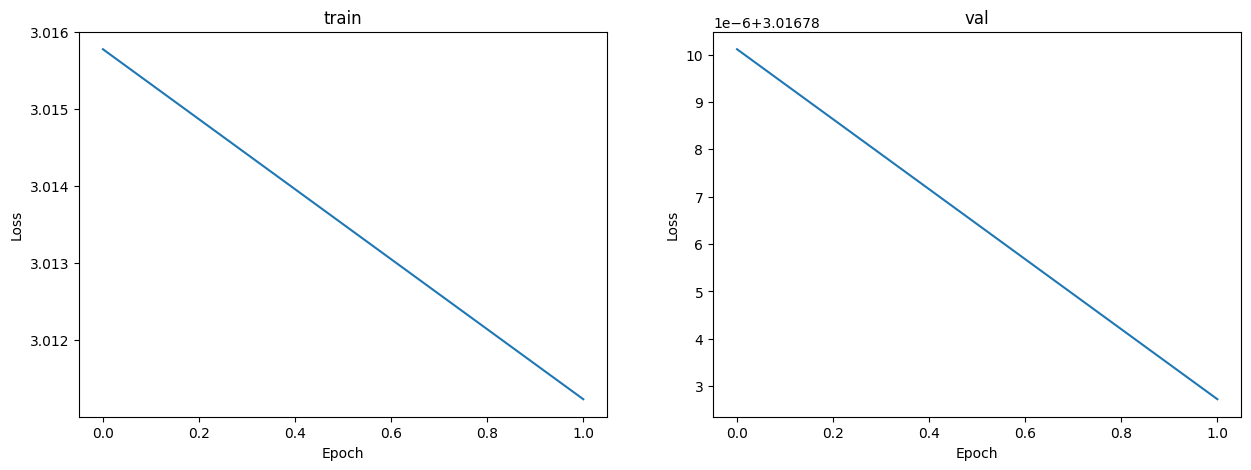

In [19]:
# Plot the cost over training and validation sets
fig,ax = plt.subplots(1,2,figsize=(15,5))
for i,key in enumerate(cost_paths.keys()):
    ax_sub=ax[i%3]
    ax_sub.plot(cost_paths[key])
    ax_sub.set_title(key)
    ax_sub.set_xlabel('Epoch')
    ax_sub.set_ylabel('Loss')
plt.show()

In [20]:
X_test

,user_id,anime_id,action,adventure,ai,arts,cars,comedy,dementia,demons,...,shounen,slice,space,sports,super,supernatural,thriller,unknown,vampire,yaoi
1160466,260755,5204,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1144869,257667,3652,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
52057,10682,20913,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
948621,214632,4999,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1031015,230920,121,1,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334229,302913,39575,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
472728,104698,31109,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
215585,50275,37722,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
767660,173780,5341,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
def predict_rating(model, userId, animeId, genre, device):

    # Get predicted rating
    model = model.to(device)
    with torch.no_grad():
        model.eval()
        user_anime_tensor = torch.tensor([userId, animeId])
        genre_tensor = torch.tensor(genre.values[0])

        concat_tensor = torch.cat((user_anime_tensor, genre_tensor))

        X = concat_tensor.long().view(1,-1)
        X = X.to(device)

        pred = model.forward(X)
        return pred

# Get the predicted rating for a random user-item pair
rating = predict_rating(model,userId=34,animeId=10,genre=X_test.loc[(X_test['user_id'] == 260755) & (X_test['anime_id'] == 5204), X_test.columns[2:]], device=device)
print('Predicted rating is {:.1f}'.format(rating.detach().cpu().item()))

Predicted rating is 5.0


In [25]:
# prompt: 选取X_test中anime_id=12,user_id=2的行，只包括第二列及以后

X_test.loc[(X_test['user_id'] == 260755) & (X_test['anime_id'] == 5204), X_test.columns[2:]]


,action,adventure,ai,arts,cars,comedy,dementia,demons,drama,ecchi,...,shounen,slice,space,sports,super,supernatural,thriller,unknown,vampire,yaoi
1160466,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [ ]:
# def generate_recommendations(animes,X,model,userId,encoder,device):
#     # Get predicted ratings for every movie
#     pred_ratings = []
#     for anime in animes['MAL_ID'].tolist():
#         genre = animes.loc[animes['MAL_ID']==anime,'Genres']
#         sypnopsis = animes.loc[animes['MAL_ID']==anime,'sypnopsis']
#         pred = predict_rating(model,userId,anime,genre,sypnopsis, encoder,device)
#         pred_ratings.append(pred.detach().cpu().item())
#     # Sort animes by predicted rating
#     idxs = np.argsort(np.array(pred_ratings))[::-1]
#     recs = animes.iloc[idxs]['MAL_ID'].values.tolist()
#     # Filter out animes already watched by user
#     animes_watched = X.loc[X['userId']==userId, 'MAL_ID'].tolist()
#     recs = [rec for rec in recs if not rec in animes_watched]
#     # Filter to top 10 recommendations
#     recs = recs[:10]
#     # Convert movieIDs to titles
#     recs_names = []
#     for rec in recs:
#         recs_names.append(animes.loc[animes['MAL_ID']==rec,'Genres', 'sypnopsis'].values[0])
#     return recs_names


In [92]:
def generate_recommendations(animes,X,model,userId,device):
    # Get predicted ratings for every movie
    pred_ratings = []
    for anime in animes['MAL_ID'].tolist():
        genre = animes.loc[(animes['anime_id'] == anime), animes.columns[8:]]
        pred = predict_rating(model,userId,anime,genre, device)
        pred_ratings.append(pred.detach().cpu().item())
    # Sort animes by predicted rating
    idxs = np.argsort(np.array(pred_ratings))[::-1]
    recs = animes.iloc[idxs]['MAL_ID'].values.tolist()
    # Filter out animes already watched by user
    animes_watched = X.loc[X['user_id']==userId, 'anime_id'].tolist()
    recs = [rec for rec in recs if not rec in animes_watched]
    # Filter to top 10 recommendations
    recs = recs[:10]
    # Convert movieIDs to titles
    recs_names = []
    print(recs)
    for rec in recs:
        recs_names.append(animes.loc[animes['MAL_ID']==rec, 'Name'].values[0])
    return recs_names


In [81]:
ratings.head()

,user_id,anime_id,rating,action,adventure,ai,arts,cars,comedy,dementia,...,shounen,slice,space,sports,super,supernatural,thriller,unknown,vampire,yaoi
0,34,13767,9,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,34,1735,10,1,1,0,1,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,34,9624,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,34,53,7,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,34,5112,7,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
animes = pd.read_csv(os.path.join(datapath,'anime_with_synopsis.csv'))
animes = pd.merge(animes, ratings, left_on='MAL_ID', right_on='anime_id', how='inner')
animes = animes.groupby('MAL_ID').max().reset_index()
animes

,MAL_ID,Name,Score,Genres,sypnopsis,user_id,anime_id,rating,action,adventure,...,shounen,slice,space,sports,super,supernatural,thriller,unknown,vampire,yaoi
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever...",353168,1,10,1,1,...,0,0,1,0,0,0,0,0,0,0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",353168,5,10,1,0,...,0,0,1,0,0,0,0,0,0,0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0...",353168,6,10,1,1,...,1,0,0,0,0,0,0,0,0,0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,352588,7,10,1,0,...,0,0,0,0,0,1,0,0,0,0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...,344839,8,10,0,1,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11606,47402,Heikousen,7.52,"Music, Romance","usic video for Eve and suis' song Heikousen , ...",320421,47402,9,0,0,...,0,0,0,0,0,0,0,0,0,0
11607,47614,Nu Wushen de Canzhuo Spring Festival Special,6.83,"Slice of Life, Comedy",No synopsis information has been added to this...,350607,47614,10,0,0,...,0,1,0,0,0,0,0,0,0,0
11608,47616,Yakusoku no Neverland 2nd Season: Michishirube,4.81,"Mystery, Psychological, Supernatural, Thriller...",cap of the first season of Yakusoku no Neverla...,341076,47616,10,0,0,...,1,0,0,0,0,1,1,0,0,0
11609,47618,Ichi Nichi Shite Narazu,Unknown,Slice of Life,The story follows an office worker Mitsuki who...,307458,47618,5,0,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
animes

In [ ]:

model = NNHybridFiltering(n_users,
                       n_items,
                       n_genres,
                       embdim_users=50,
                       embdim_items=50,
                       embdim_genres=25,
                       n_activations = 100,
                       rating_range=[1.,10.])
model.load_state_dict(torch.load('./model/ncf_model.pt'))

In [93]:
# Get recommendations for a random user
userId = 260755
recs = generate_recommendations(animes.iloc[0:2000],X_test,model,userId,device)
for i,rec in enumerate(recs):
  print('Recommendation {}: {}'.format(i,rec))

[452, 451, 450, 449, 1397, 2098, 573, 249, 808, 1224]
Recommendation 0: InuYasha Movie 1: Toki wo Koeru Omoi
Recommendation 1: InuYasha Movie 3: Tenka Hadou no Ken
Recommendation 2: InuYasha Movie 2: Kagami no Naka no Mugenjo
Recommendation 3: InuYasha Movie 4: Guren no Houraijima
Recommendation 4: Macross 7
Recommendation 5: Shin Kimagure Orange☆Road: Soshite, Ano Natsu no Hajimari
Recommendation 6: Saber Marionette J
Recommendation 7: InuYasha
Recommendation 8: Bakuretsu Hunters OVA
Recommendation 9: Aquarian Age: Sign for Evolution
